<a href="https://colab.research.google.com/github/2303A51833/ADM/blob/main/Adm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-5163c8a5de45>:57: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['cluster'].iloc[1:] = kmeans.labels_  # Skip the first row as it has no previous transaction
<ipython-input-1-5163c8a5de45>:57: SettingWithCopyWarning: 
A va

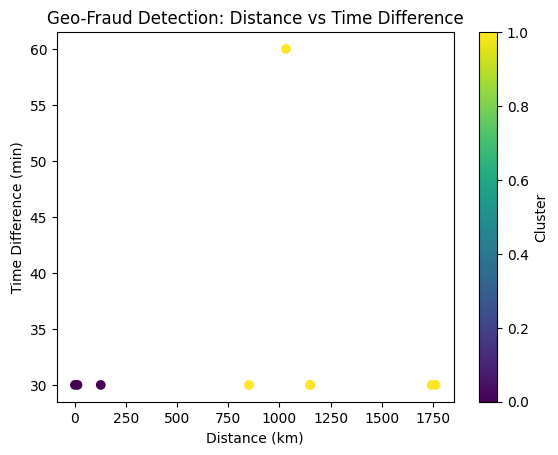

Transaction 1: User 1, Distance: 14.43 km, Time Difference: 30.00 min, Cluster: 0
Transaction 2: User 1, Distance: 1149.61 km, Time Difference: 30.00 min, Cluster: 1
Transaction 3: User 1, Distance: 1149.61 km, Time Difference: 30.00 min, Cluster: 1
Transaction 4: User 2, Distance: 1742.65 km, Time Difference: 30.00 min, Cluster: 1
Transaction 5: User 2, Distance: 127.90 km, Time Difference: 30.00 min, Cluster: 0
Transaction 6: User 2, Distance: 851.64 km, Time Difference: 30.00 min, Cluster: 1
Transaction 7: User 3, Distance: 1031.87 km, Time Difference: 60.00 min, Cluster: 1
Transaction 8: User 3, Distance: 1.89 km, Time Difference: 30.00 min, Cluster: 0
Transaction 9: User 3, Distance: 1762.28 km, Time Difference: 30.00 min, Cluster: 1

Suspicious Transactions Detected:
   user_id           timestamp  latitude  longitude  cluster
2        1 2025-04-20 11:00:00   19.0760    72.8777        1
3        1 2025-04-20 11:30:00   28.7041    77.1025        1
4        2 2025-04-20 12:00:00   

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from datetime import datetime
import matplotlib.pyplot as plt

# Sample data for ATM transactions (User ID, Transaction Timestamp, Latitude, Longitude)
data = [
    {'user_id': 1, 'timestamp': '2025-04-20 10:00:00', 'latitude': 28.6139, 'longitude': 77.2090},  # Delhi
    {'user_id': 1, 'timestamp': '2025-04-20 10:30:00', 'latitude': 28.7041, 'longitude': 77.1025},  # Delhi
    {'user_id': 1, 'timestamp': '2025-04-20 11:00:00', 'latitude': 19.0760, 'longitude': 72.8777},  # Mumbai
    {'user_id': 1, 'timestamp': '2025-04-20 11:30:00', 'latitude': 28.7041, 'longitude': 77.1025},  # Delhi
    {'user_id': 2, 'timestamp': '2025-04-20 12:00:00', 'latitude': 12.9716, 'longitude': 77.5946},  # Bangalore
    {'user_id': 2, 'timestamp': '2025-04-20 12:30:00', 'latitude': 12.2958, 'longitude': 76.6394},  # Mysore
    {'user_id': 2, 'timestamp': '2025-04-20 13:00:00', 'latitude': 19.0760, 'longitude': 72.8777},  # Mumbai
    {'user_id': 3, 'timestamp': '2025-04-20 14:00:00', 'latitude': 13.0827, 'longitude': 80.2707},  # Chennai
    {'user_id': 3, 'timestamp': '2025-04-20 14:30:00', 'latitude': 13.0674, 'longitude': 80.2785},  # Chennai
    {'user_id': 3, 'timestamp': '2025-04-20 15:00:00', 'latitude': 28.7041, 'longitude': 77.1025},  # Delhi
]

# Convert to DataFrame
df = pd.DataFrame(data)

# Convert timestamps to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Function to calculate the distance between two lat-long points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Extract features: Latitude, Longitude, and Time Difference (in minutes)
features = []
for i in range(1, len(df)):
    prev_transaction = df.iloc[i-1]
    current_transaction = df.iloc[i]

    # Calculate time difference in minutes
    time_diff = (current_transaction['timestamp'] - prev_transaction['timestamp']).total_seconds() / 60.0

    # Calculate distance between successive ATM locations
    distance = calculate_distance(prev_transaction['latitude'], prev_transaction['longitude'],
                                   current_transaction['latitude'], current_transaction['longitude'])

    # Append features (distance and time difference)
    features.append([distance, time_diff])

# Convert features to numpy array for clustering
X = np.array(features)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2)  # We assume there are 2 clusters (normal and anomalous)
kmeans.fit(X)

# Assign clusters to the data
df['cluster'] = -1
df['cluster'].iloc[1:] = kmeans.labels_  # Skip the first row as it has no previous transaction

# Visualize the clusters (Distance vs. Time Difference)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', marker='o')
plt.title('Geo-Fraud Detection: Distance vs Time Difference')
plt.xlabel('Distance (km)')
plt.ylabel('Time Difference (min)')
plt.colorbar(label='Cluster')
plt.show()

# Print out transactions with their assigned clusters
for i in range(1, len(df)):
    print(f"Transaction {i}: User {df.iloc[i]['user_id']}, Distance: {X[i-1][0]:.2f} km, "
          f"Time Difference: {X[i-1][1]:.2f} min, Cluster: {df.iloc[i]['cluster']}")

# Example of detecting a suspicious transaction
suspicious_transactions = df[df['cluster'] == 1]  # Let's say cluster 1 is suspicious
print("\nSuspicious Transactions Detected:")
print(suspicious_transactions)